In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D, LSTM
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import SpatialDropout1D, concatenate, TimeDistributed
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.callbacks import Callback
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# Import precleaned text data
input_prefix = '20newsgroups_pols_cleaned_nh'

df_train = pd.read_csv(input_prefix + '_train.csv')
df_test = pd.read_csv(input_prefix + '_test.csv')

In [3]:
# Split of targets
y_train = df_train['target']
y_test = df_test['target']

In [4]:
# One Hot encode target data
encoder = OneHotEncoder(sparse=False)

y_train = encoder.fit_transform(y_train.values.reshape(-1,1))
y_test = encoder.fit_transform(y_test.values.reshape(-1,1))

C:\Users\brbenson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\brbenson\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warnin

In [5]:
# Tokenize text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_train.text)

X_train = tokenizer.texts_to_sequences(df_train.text)
X_test = tokenizer.texts_to_sequences(df_test.text)

# Save total number of words in vocabulary to be used later
vocab_size = len(tokenizer.word_index) + 1

In [6]:
# Set max length of text vector for each article
maxlen = 2000

# Pad articles with fewer than maxlen tokens
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [7]:
# Define plotting function to show accuracy/loss vs. epoch
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [8]:
# RNN with single GRU layer using random starting word embedding vectors 

embedding_dim = 300
embedding_matrix = np.random.random((vocab_size, embedding_dim))

inp = Input(shape=(maxlen, ))

x = Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True)(inp)

x = SpatialDropout1D(0.3)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(4, activation="sigmoid")(conc)

model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2000, 300)    9206100     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 2000, 300)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
global_ave

In [10]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Training Accuracy: 0.9846
Testing Accuracy:  0.8811


NameError: name 'history' is not defined

In [9]:
# Define function to takea line of GloVe data and return word and vector as an array
def get_coefs(word, *arr):
    try:
        return word, np.asarray(arr, dtype='float32')
    except:
        return None, None

In [11]:
# Read in GloVe word vectors as a dictionary
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('glove.840B.300d.txt', encoding="utf8"))

In [12]:
# Loop through GloVe vectors and remove any of wrong size
embed_size = 300

for k in list(embeddings_index.keys()):
    v = embeddings_index[k]
    try:
        if v.shape != (embed_size, ):
            embeddings_index.pop(k)
    except:
        pass
            
embeddings_index.pop(None)

In [21]:
# Construct a matrix of embedding values to be used as pretrained weights
values = list(embeddings_index.values())
all_embs = np.stack(values)

emb_mean, emb_std = all_embs.mean(), all_embs.std()

word_index = tokenizer.word_index
nb_words = vocab_size
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= maxlen: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


38


In [24]:
# RNN with single GRU layer using pretrained GloVe word embedding vectors 
inp = Input(shape=(maxlen, ))

x = Embedding(input_dim=vocab_size, 
              output_dim=embed_size, 
              input_length=maxlen, 
              weights=[embedding_matrix], 
              trainable=True)(inp)

x = SpatialDropout1D(0.3)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(4, activation="sigmoid")(conc)

model_2 = Model(inputs=inp, outputs=outp)
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 2000, 300)    9206100     input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 2000, 300)    0           embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_2[0][0]        
__________________________________________________________________________________________________
global_ave

In [25]:
history_2 = model_2.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model_2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_2)

Training Accuracy: 1.0000
Testing Accuracy:  0.8983


NameError: name 'history' is not defined

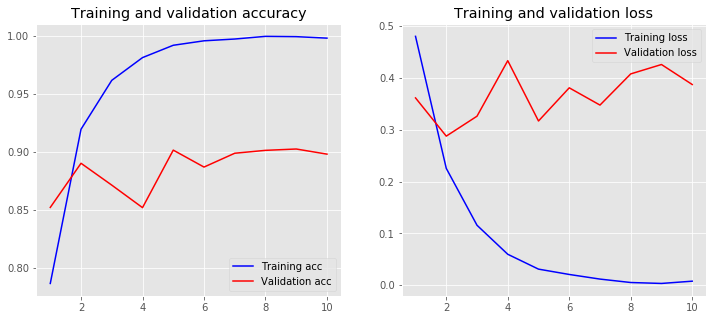

In [26]:
plot_history(history_2)

In [33]:
# Multi channel CNN (3x) with max pooling
embedding_dim = 300

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=4, activation='sigmoid')(dropout)

model_3 = Model(inputs=inputs, outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_3.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 2000, 300)    9206100     input_8[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 2000, 300, 1) 0           embedding_8[0][0]                
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 1999, 1, 256) 153856      reshape_4[0][0]                  
__________________________________________________________________________________________________
conv2d_11 

Training Accuracy: 0.9999
Testing Accuracy:  0.9001


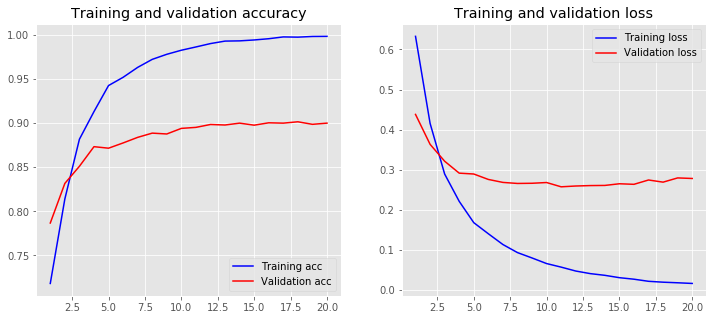

In [34]:
history_3 = model_3.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model_3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_3)

In [35]:
# RNN + CNN (Single layer each)

inp = Input(shape=(maxlen, ))
x = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True)(inp)
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(GRU(100, return_sequences=True))(x)
x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
outp = Dense(4, activation="sigmoid")(conc)

model_4 = Model(inputs=inp, outputs=outp)
model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 2000, 300)    9206100     input_9[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 2000, 300)    0           embedding_9[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 2000, 200)    240600      spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
conv1d_1 (

Training Accuracy: 1.0000
Testing Accuracy:  0.9001


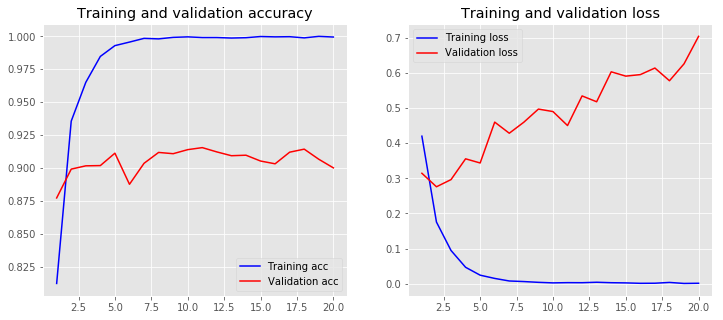

In [36]:
history_4 = model_4.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model_4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_4)

In [53]:
# Multi Channel CNN (3x) with max pooling feeding into RNN (LSTM)

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

lstm = TimeDistributed(Bidirectional(LSTM(128, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

flatten = Flatten()(lstm)
dropout = Dropout(drop)(flatten)
output = Dense(units=4, activation='sigmoid')(dropout)

model_5 = Model(inputs=inputs, outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_5.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 2000, 300)    9206100     input_23[0][0]                   
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 2000, 300, 1) 0           embedding_23[0][0]               
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 1999, 1, 256) 153856      reshape_9[0][0]                  
__________________________________________________________________________________________________
conv2d_28 

Training Accuracy: 1.0000
Testing Accuracy:  0.9091


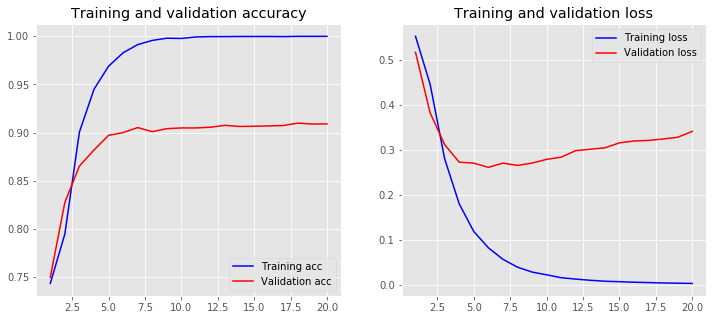

In [54]:
history_5 = model_5.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model_5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_5)

In [46]:
# RNN (GRU) feeding into Multi Channel CNN (3x) with max pooling

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')
embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

x = SpatialDropout1D(0.3)(embedding)
x = Bidirectional(GRU(100, return_sequences=True))(x)

conv_0 = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)

conv_1 = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "he_uniform")(x)

conv_2 = Conv1D(64, kernel_size = 5, padding = "valid", kernel_initializer = "he_uniform")(x)

maxpool_0 = GlobalMaxPooling1D()(conv_0)

maxpool_1 = GlobalMaxPooling1D()(conv_1)

maxpool_2 = GlobalMaxPooling1D()(conv_2)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

flatten = Dense(units=128, activation='sigmoid')(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=4, activation='sigmoid')(dropout)

model_6 = Model(inputs=inputs, outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_6.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 2000, 300)    9206100     input_18[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_9 (SpatialDro (None, 2000, 300)    0           embedding_18[0][0]               
__________________________________________________________________________________________________
bidirectional_12 (Bidirectional (None, 2000, 200)    240600      spatial_dropout1d_9[0][0]        
__________________________________________________________________________________________________
conv1d_16 

Training Accuracy: 0.9968
Testing Accuracy:  0.8909


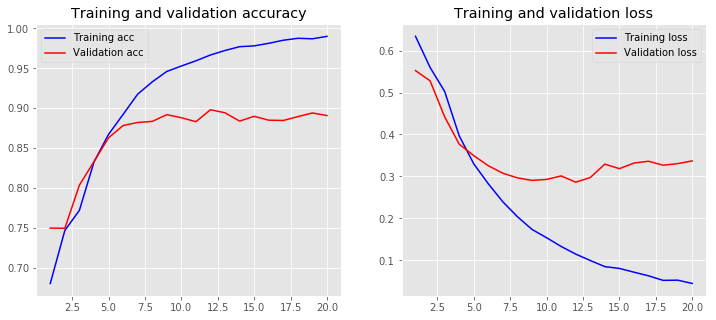

In [47]:
history_6 = model_6.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model_6.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_6.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_6)

In [59]:
# Multi Channel CNN (3x) with max pooling feeding into 
# Multi Channel RNN (LSTM 3x)

embedding_dim = 300

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')

embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_0)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_1)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

lstm_0 = TimeDistributed(Bidirectional(LSTM(64, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_1 = TimeDistributed(Bidirectional(LSTM(128, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_2 = TimeDistributed(Bidirectional(LSTM(256, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

concatenated_tensor_2 = Concatenate(axis=2)(
    [lstm_0, lstm_1, lstm_2])

flatten = Flatten()(concatenated_tensor_2)
dropout = Dropout(drop)(flatten)
output = Dense(units=4, activation='sigmoid')(dropout)

model_7 = Model(inputs=inputs, outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_7.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_7.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 2000, 300)    9206100     input_27[0][0]                   
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 2000, 300, 1) 0           embedding_27[0][0]               
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 1999, 1, 256) 153856      reshape_13[0][0]                 
__________________________________________________________________________________________________
conv2d_40 

Training Accuracy: 1.0000
Testing Accuracy:  0.9103


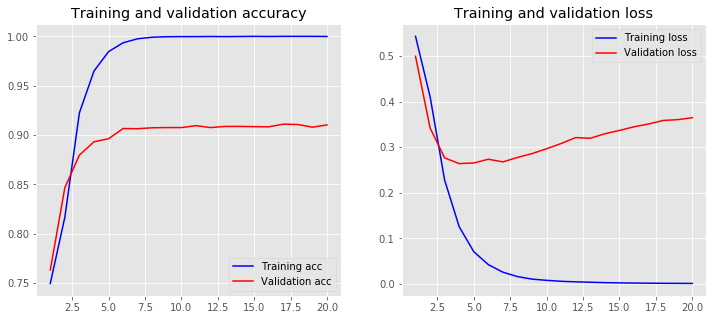

In [60]:
history_7 = model_7.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model_7.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_7.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_7)

In [65]:
from keras.layers import BatchNormalization, Activation

In [66]:
# Multi Channel CNN (3x) with batch normalization and max pooling 
# feeding into Multi Channel RNN (LSTM 3x)
embedding_dim = 300

filter_sizes = [2, 3, 5]
num_filters = 256
drop = 0.3

inputs = Input(shape=(maxlen,), dtype='int32')
embedding = Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)(inputs)

reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

conv_0 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[0], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

batch_0 = BatchNormalization(axis=1)(conv_0)

act_0 = Activation('relu')(batch_0)

maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1), 
                      strides=(1,1), padding='valid')(act_0)

conv_1 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[1], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

batch_1 = BatchNormalization(axis=1)(conv_1)

act_1 = Activation('relu')(batch_1)

maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1), 
                      strides=(1,1), padding='valid')(act_1)

conv_2 = Conv2D(num_filters, 
                kernel_size=(filter_sizes[2], embedding_dim), 
                padding='valid', kernel_initializer='normal', 
                activation='relu')(reshape)

batch_2 = BatchNormalization(axis=1)(conv_2)

act_2 = Activation('relu')(batch_2)

maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1), 
                      strides=(1,1), padding='valid')(act_2)

concatenated_tensor = Concatenate(axis=1)(
    [maxpool_0, maxpool_1, maxpool_2])

lstm_0 = TimeDistributed(Bidirectional(LSTM(64, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_1 = TimeDistributed(Bidirectional(LSTM(128, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

lstm_2 = TimeDistributed(Bidirectional(LSTM(256, 
                       return_sequences=False, 
                       dropout=0.15, 
                       recurrent_dropout=0.15, 
                       implementation=0)))(concatenated_tensor)

concatenated_tensor_2 = Concatenate(axis=2)(
    [lstm_0, lstm_1, lstm_2])

flatten = Flatten()(concatenated_tensor_2)
dropout = Dropout(drop)(flatten)
output = Dense(units=4, activation='sigmoid')(dropout)

model_8 = Model(inputs=inputs, outputs=output)
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_8.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_8.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 2000)         0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 2000, 300)    9206100     input_30[0][0]                   
__________________________________________________________________________________________________
reshape_16 (Reshape)            (None, 2000, 300, 1) 0           embedding_30[0][0]               
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 1999, 1, 256) 153856      reshape_16[0][0]                 
__________________________________________________________________________________________________
conv2d_45 

Training Accuracy: 1.0000
Testing Accuracy:  0.9112


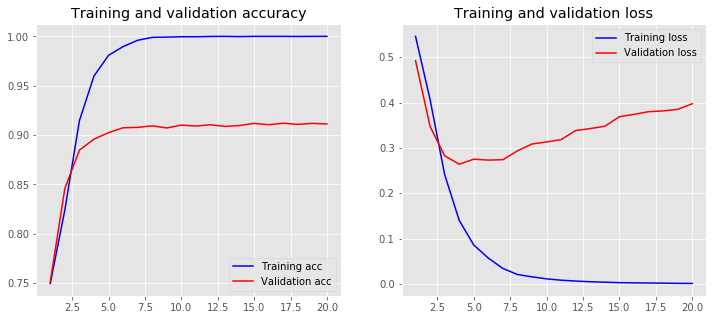

In [67]:
history_8 = model_8.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

loss, accuracy = model_8.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_8.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_8)